In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import libs.synthcatalogue as syc
import libs.maptool as mp
import libs.csvcat as cc
import libs.mfdtool as mfd

# Synthetic Catalogue Generator Demo
The synthcatalogue library provides an easy way to to create and export stochastically generated catalogues.<br>
A synthetic catalogue is obatained using a double truncated G-R relation and assuming the time distribution of the events to be Poissonian. The inverse sampling method is used to generate random samples from such distributions.<br>

## Catalogue generation
Each catalogue can be generated starting from a given time instant (year, month, day, hour, minute and second) over a given range of years.<br>
Spatial distribution can be point source, finite fault or (uniform) area source, while depth distribution is at the moment just uniform within min. and max. depth bounds.<br>

### 1- Point source

In [2]:
cfg1 = {'aValue' : 10.,
        'bValue' : 1.,
        'MinMag' : 4.,
        'MaxMag' : 8.,
        'Years' : 100.,
        'Source' : [[25., -10.]],
        'Depth': [0.,50.],
        'Date' : [1900.,01.,01.,00.,00.,00.]}

cat1 = syc.catalogue(cfg1)
cat1.generate()

### 2 - Fault Trace

In [3]:
cfg2 = {'aValue' : 10.,
        'bValue' : 1.,
        'MinMag' : 4.,
        'MaxMag' : 8.,
        'Years' : 100.,
        'Source' : [[22.,-18.], [28.,-12.]],
        'Depth': [0., 50.],
        'Date' : [1900.,01.,01.,00.,00.,00.]}

cat2 = syc.catalogue(cfg2)
cat2.generate()

### 3 - Area Source

In [4]:
# Note that area is defined as closed-loop polygon
# Rates are defines as number of events per year and unit area!
cfg3 = {'aValue' : 1,
        'bValue' : 1.,
        'MinMag' : 4.,
        'MaxMag' : 8.,
        'Years' : 100.,
        'Source' : [[20., -20.],[20., 0.],[25., 0.],[30., -10.],[30.,-20.],[20., -20.]],
        'Depth': [0., 50.],
        'Date' : [1900.,01.,01.,00.,00.,00.]}

cat3 = syc.catalogue(cfg3)
cat3.generate()

### Merging catalogues

In [5]:
cat3.append(cat2)

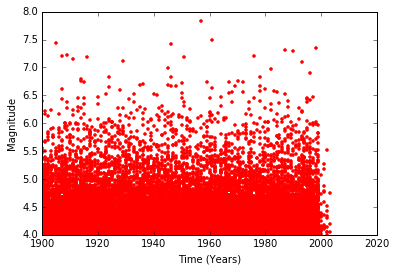

In [6]:
plt.figure();
plt.plot(cat3.year,cat3.magnitude,'r.');
plt.xlabel('Time (Years)');
plt.ylabel('Magnitude');

The append() method is also useful to create catalogue with special characteristics, e.g. particular depth distributions. This can be done "indirectly" by merging several catalogues defined over different depth ranges.

In [7]:
cfg3['aValue'] = 0.8
cfg3['Depth'] = [0., 10.]
cat3_a = syc.catalogue(cfg3)
cat3_a.generate()

cfg3['aValue'] = 0.18
cfg3['Depth'] = [10., 30.]
cat3_b = syc.catalogue(cfg3)
cat3_b.generate()

cfg3['aValue'] = 0.02
cfg3['Depth'] = [30., 50.]
cat3_c = syc.catalogue(cfg3)
cat3_c.generate()

cat3_a.append(cat3_b)
cat3_a.append(cat3_c)

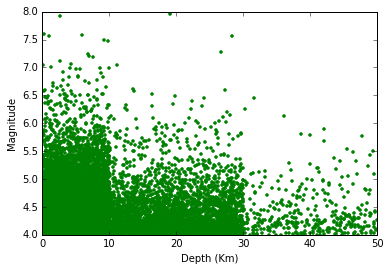

In [8]:
plt.figure();
plt.plot(cat3_a.depth,cat3_a.magnitude,'g.');
plt.xlabel('Depth (Km)');
plt.ylabel('Magnitude');

### Adding artificial completeness
Completeness can be added artificially by defining completeness windows, not necessairly contiguous. Any event not included in the specified windows is implicitly rejected.

In [9]:
comp_win = [[4, 5, 1970, 2015],
            [5, 5.5, 1950, 1960],
            [5, 5.5, 1965, 2015],
            [5.5, 6, 1935, 2015],
            [6, 8, 1900, 2015]]

cat3.completeness(comp_win)

NOTE: Although more complicated, the same result can nevertheless be achieved by creating and merging subcatalogues initialised over the different time (completeness) windows

In [10]:
print 'Number of synthetic events:', cat3.catlen

Number of synthetic events: 5984


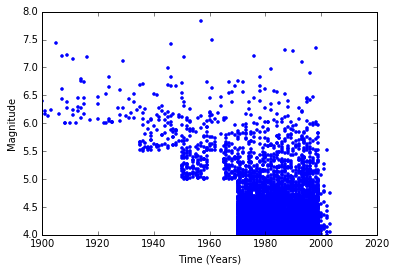

In [11]:
plt.figure();
plt.plot(cat3.year,cat3.magnitude,'b.');
plt.xlabel('Time (Years)');
plt.ylabel('Magnitude');

### Exporting the final catalogue

In [12]:
cat3_file = 'data/example.csv'

cat3.export(cat3_file)

### MFD Plot (Experimental, to develop further)

In [13]:
%config InlineBackend.close_figures=False

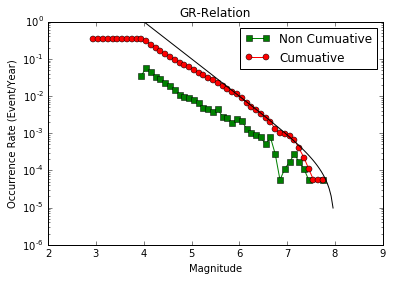

In [14]:
a = 1
b = 1
Mmin = 4
Mmax = 8
Bins = 0.1

C = cat3.magnitude
Time = np.max(cat3.year)-np.min(cat3.year)
Area = cat3.area

# MFD from synthetic catalogue
mbin, mhst, chst = mfd.mfdhist(C,Mmin-1,Mmax+1,Bins,Time,Area)
mfd.mfdplot(mbin,mhst,chst)

# Theoretical MFD
mbin, mfda = mfd.mfdanalytic(a,b,Mmin,Mmax,100)
plt.semilogy(mbin,mfda,'k');

In [15]:
%config InlineBackend.close_figures=True
plt.close('all')

## Catalogue I/O example

In [16]:
header = ['Year',
          'Month',
          'Day',
          'Hour',
          'Minute',
          'Second',
          'Latitude',
          'Longitude',
          'Depth',
          'Magnitude',
          'Sigma']

In [17]:
# Using an header which is same of default one for demonstration.
# n.b. GEM format can be parsed identically.
csv = cc.catalogue(header=header)
csv.csv_import(cat3_file, skipline=1)

# Filter by magnitude (new catalogue is initialised)
csv_sel = csv.filter('Magnitude',dmin=6.5,dmax=8)

# Casting coordinates to Numpy array
lon = np.array(csv.extract('Longitude'))
lat = np.array(csv.extract('Latitude'))

lon_sel = np.array(csv_sel.extract('Longitude'))
lat_sel = np.array(csv_sel.extract('Latitude'))

## Map plot example

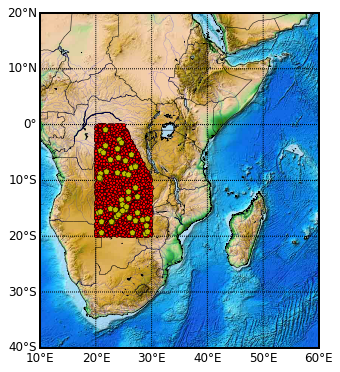

In [18]:
m = mp.geomap()

m.cfg['Bounds'] = [10., -40., 60., 20.]
m.cfg['Background']= ['etopo']
m.cfg['Grid'] = [10., 10.]

m.baseplot()
m.pointplot(lon,lat,['o','r',3]) # Makeup is [symbol, color, size]
m.pointplot(lon_sel,lat_sel,['p','y',7])
m.show()